# Projet : Physique des matériaux
## Louis Noirot
###### LMAPR1492

In [1]:
import numpy as np
import itertools
from mp_api.client import MPRester

from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from pymatgen.analysis.structure_matcher import StructureMatcher
from pymatgen.io.cif import CifWriter
from pymatgen.electronic_structure.core import Spin
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.symmetry.bandstructure import HighSymmKpath

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

from jupyter_jsmol.pymatgen import quick_view
from jupyter_jsmol import JsmolView
from ipywidgets import Layout, widgets, interact
from IPython.display import display

In [2]:
mp_key = "g2nCFD5rMkPRt9qdpOGhbfHJf2mgbv5x"
mp_id = "mp-14116"

In [3]:
hbarre = 6.62607015e-34/(2*np.pi)
eV = 1.6022e-19 # pour passer de J à eV
A = 1e-10
toHz = 1e12 # pour passer de THz à Hz

In [4]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
    structure = m.get_structure_by_material_id(mp_id)
    band = m.get_bandstructure_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Exporter en CIF avec symétries
writer = CifWriter(conv_struc, symprec=0.01)
writer.write_file("data/CuRhO2_fixed.cif")

# Tâche 7:
#### 1) Trouver la direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion (insérer une figure indiquant la dispersion par des flèches)
#### 2) calculer la masse effective au sommet (base) de la dernière (première) bande de valence (conduction) en supposant une dispersion parabolique.

## Bande interdite: 

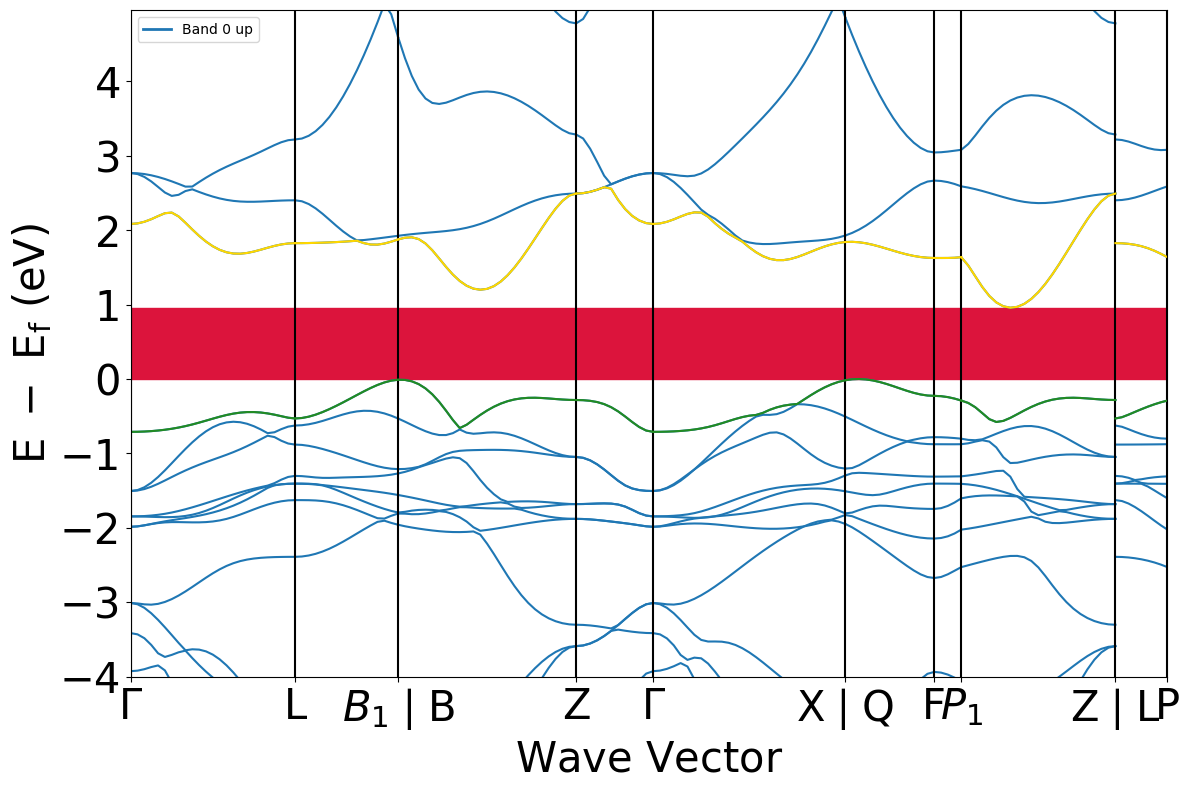

La largeur de la bande interdite est de: 0.9581 [eV].
La bande interdite de ce matériau est indirect.
La transistion est en: (0.634,0.366,0.000)-(0.608,0.608,0.284).


In [6]:
bs_plot_data = BSPlotter(el_bs).bs_plot_data()
distance = bs_plot_data.get('ticks').get('distance')
distances = bs_plot_data.get('distances')
energy = bs_plot_data.get('energy')

vbm_band_index = el_bs.get_vbm()['band_index'][Spin.up][-1]  # Bande de valence n°1
cbm_band_index = el_bs.get_cbm()['band_index'][Spin.up][0]   # Bande de conduction n°1

BSPlotter(el_bs).get_plot()

for i in range(len(distances)):
    plt.plot(distances[i], energy.get('1')[i][vbm_band_index], 'forestgreen') 
    plt.plot(distances[i], energy.get('1')[i][cbm_band_index], 'gold') 

plt.fill_between(np.linspace(distance[0], distance[-1], 2), 0, el_bs.get_band_gap().get('energy'), color = "crimson")

plt.show()

print(f"La largeur de la bande interdite est de: {el_bs.get_band_gap().get('energy')} [eV].")
if el_bs.get_band_gap().get('direct') is True:
    print("La bande interdite de ce matériau est direct.")
if el_bs.get_band_gap().get('direct') is False:
    print("La bande interdite de ce matériau est indirect.")
print(f"La transistion est en: {el_bs.get_band_gap().get('transition')}.")

In [7]:
bsplot = BSPlotter(el_bs)
bsdata = bsplot.bs_plot_data()

vbm = el_bs.get_vbm()
cbm = el_bs.get_cbm()

indices_vbm = list(vbm["band_index"].get(Spin.up, []))  
indices_cbm = list(cbm["band_index"].get(Spin.up, []))  

kpoint_vbm = vbm["kpoint"].cart_coords
kpoint_cbm = cbm["kpoint"].cart_coords

print("\n* Dernière bande de valence:")
print(f" - Énergie du maximum de la bande de valence = {vbm['energy']} [eV].")
print(f" - Vecteur k en coordonnées cartésiennes = {kpoint_vbm}.")
print(f" - Indices des bandes de valence : {indices_vbm}.")

print("\n* Première bande de conduction:")
print(f" - Énergie minimum de la bande de conduction = {cbm['energy']} [eV].")
print(f" - Vecteur k en coordonnées cartésiennes = {kpoint_cbm}.")
print(f" - Indices des bandes de conduction: {indices_cbm}.")


* Dernière bande de valence:
 - Énergie du maximum de la bande de valence = 4.1447 [eV].
 - Vecteur k en coordonnées cartésiennes = [ 0.54246208 -0.53688287 -1.08547671].
 - Indices des bandes de valence : [21].

* Première bande de conduction:
 - Énergie minimum de la bande de conduction = 5.1028 [eV].
 - Vecteur k en coordonnées cartésiennes = [ 0.65957477  0.         -0.65425884].
 - Indices des bandes de conduction: [22].


In [8]:
x = np.unique(bsdata["ticks"]["distance"])  
y = bsdata["energy"]

n = len(x)-1

dx = np.zeros(n)
dyc = np.zeros(n)
dyv = np.zeros(n)
mc = np.zeros(n)
mv = np.zeros(n)

for i in range(n):
    dx[i] = x[i+1] - x[i]
    
for i in range(n):
    dyv[i] =y.get('1')[i][21][-1] - y.get('1')[i][21][0]
    dyc[i] =y.get('1')[i][22][-1] - y.get('1')[i][22][0]
    
for i in range (n):
    mc[i] = dyc[i]/dx[i]
    mv[i] = dyv[i]/dx[i] 
    
valence_max = np.max(abs(mv))
indice_valance_max = np.argmax(abs(mv))
valence_min = np.min(abs(mv))
indice_valance_min = np.argmin(abs(mv))
conduction_max = np.max(abs(mc))
indice_conduction_max = np.argmax(abs(mc))
conduction_min = np.min(abs(mc))
indice_conduction_min = np.argmin(abs(mc))

print("* Dernière bande de valance:")
print(f" - La plus grande dispersion (en valeur absolue) est de : {valence_max} et est d'indice {indice_valance_max}.")
print(f" - La plus petite dispersion (en valeur absolue) est de : {valence_min} et est d'indice {indice_valance_min}.")

print("\n\n* Première bande de conduction:")
print(f" - La plus grande dispersion (en valeur absolue) est de : {conduction_max} et est d'indice {indice_conduction_max}.")
print(f" - La plus petite dispersion (en valeur absolue) est de : {conduction_min} et est d'indice {indice_conduction_min}.")

* Dernière bande de valance:
 - La plus grande dispersion (en valeur absolue) est de : 0.7789346909829871 et est d'indice 3.
 - La plus petite dispersion (en valeur absolue) est de : 0.006642506748954381 et est d'indice 7.


* Première bande de conduction:
 - La plus grande dispersion (en valeur absolue) est de : 0.7775372626002226 et est d'indice 7.
 - La plus petite dispersion (en valeur absolue) est de : 0.05572339571100406 et est d'indice 6.


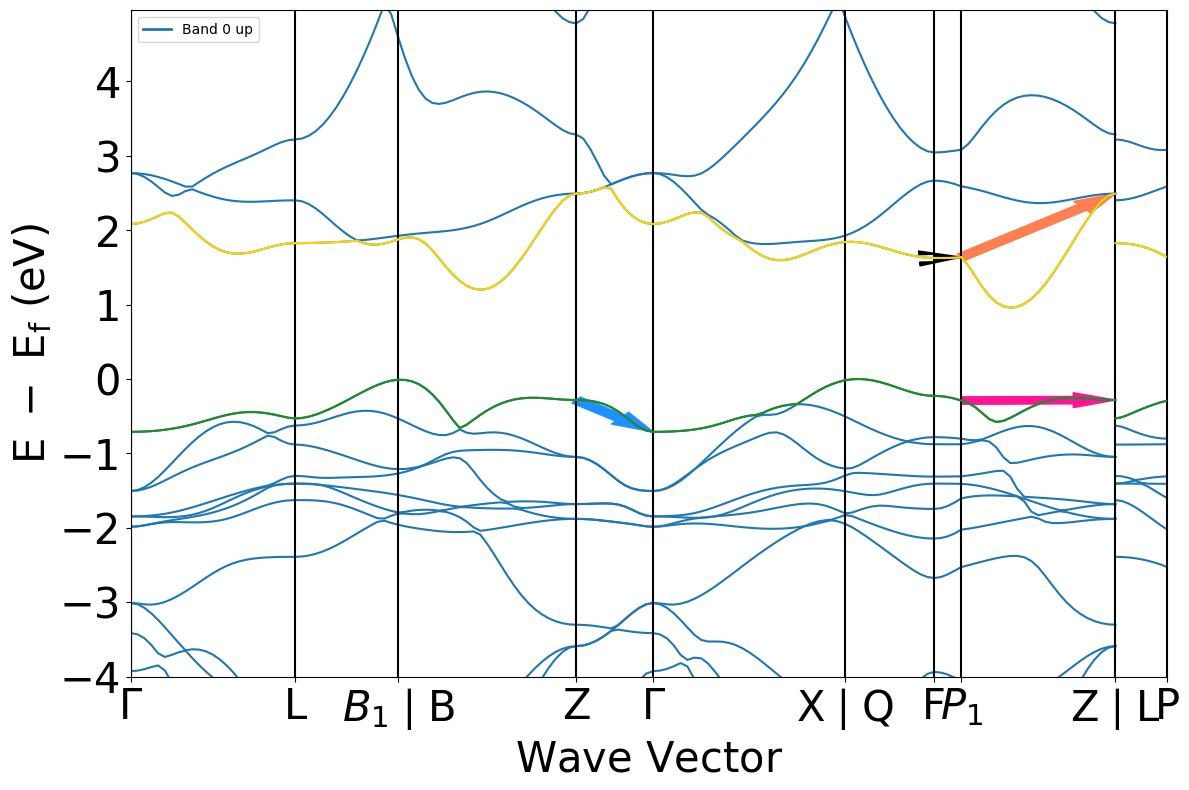

In [9]:
bsplot.get_plot()

d = len(distances)

for i in range(d):
    plt.plot(distances[i], energy['1'][i][vbm_band_index], 'forestgreen') 
    plt.plot(distances[i], energy['1'][i][cbm_band_index], 'gold')   

plt.arrow(x[indice_valance_max], 
          y["1"][indice_valance_max][21][0], 
          dx[indice_valance_max], 
          dyv[indice_valance_max], 
          color='dodgerblue', width=0.1, head_width=0.2, length_includes_head=True)

plt.arrow(x[indice_valance_min], 
          y["1"][indice_valance_min][21][0], 
          dx[indice_valance_min], 
          dyv[indice_valance_min], 
          color='deeppink', width=0.1, head_width=0.2, length_includes_head=True) 

plt.arrow(x[indice_conduction_max], 
          y["1"][indice_conduction_max][22][0], 
          dx[indice_conduction_max],
          dyc[indice_conduction_max], 
          color='coral', width=0.1, head_width=0.2, length_includes_head=True)

plt.arrow(x[indice_conduction_min], 
          y["1"][indice_conduction_min][22][0], 
          dx[indice_conduction_min], 
          dyc[indice_conduction_min], 
          color='black', width=0.1, head_width=0.2, length_includes_head=True)

plt.show()

Pour calculer les masses effectives en supposant une dispersion parabolique, on utilise la formule suivante :  

$$E(k) = \frac{\hbar^2k^2}{2m^*}$$ 

On trouve donc la masse effective comme ceci :  

$$m^* = \frac{\hbar^2(k_x^2 + k_y^2 + k_z^2)}{2E(k)}$$ 

In [10]:
Valence_k = el_bs.get_vbm()['kpoint'].frac_coords
Cond_k = el_bs.get_cbm()['kpoint'].frac_coords

Valence_energy = el_bs.get_vbm()['energy'] 
Cond_energy = el_bs.get_cbm()['energy'] 

Valence_masse = (hbarre**2*(Valence_k[0]**2+Valence_k[1]**2+Valence_k[2]**2))/(2*Valence_energy*eV*A**2)
Cond_masse = (hbarre**2*(Cond_k[0]**2+Cond_k[1]**2+Cond_k[2]**2))/(2*Cond_energy*eV*A**2)

print(f"La masse effective au sommet de la dernière bande de valence est de {Valence_masse} [kg].")
print(f"La masse effective à la base de la première bande de conduction est de {Cond_masse} [kg].")

La masse effective au sommet de la dernière bande de valence est de 4.487350317599023e-31 [kg].
La masse effective à la base de la première bande de conduction est de 5.576542710579682e-31 [kg].
